$\gamma$ Ray Burst (GRB)

We have to explore the following data set and cluster the fast and slow GRB. Then, compare with the literature.

In [122]:
import requests
import numpy as np
import matplotlib.pyplot as plt

# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

# Read content
data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')


# Read headers
with open("Summary_table.txt",'r') as f:
    names = np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])



In [123]:
#fluence
fluence = data[9]
#T_90
T90 = data[6]

Let's see at the data set: here I plot the same quantities shown in the notes

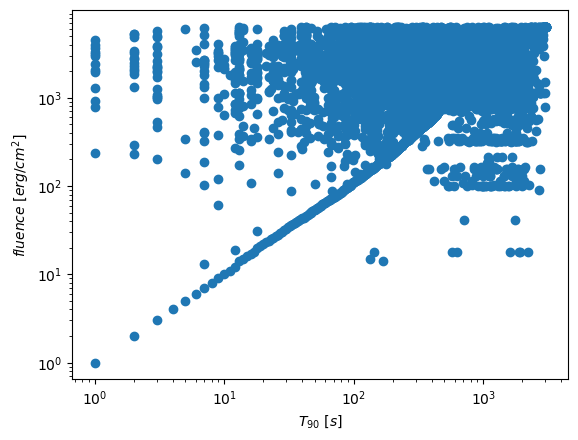

In [124]:
plt.scatter(T90, fluence)
plt.xlabel('$T_{90} \ [s]$')
plt.ylabel('$fluence \ [erg/cm^2]$')
plt.xscale('log')
plt.yscale('log')

There are non-real values (-999) to eliminate.

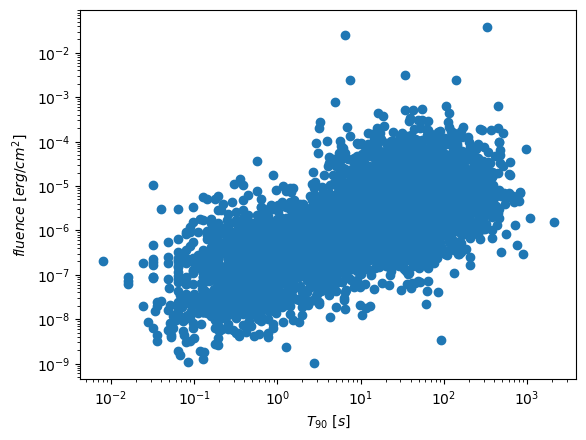

In [125]:
for i in range (0,len(T90)):
    if fluence[i] == '-999' or T90[i] == '-999' :
        fluence[i] = 0
        T90[i] = 0


fluence_clean = fluence[fluence != '0']
T90_clean = T90[T90 != '0']


T90_arr = np.array(T90_clean, dtype=float)
fluence_arr = np.array(fluence_clean, dtype=float)

plt.scatter(T90_arr, fluence_arr)
plt.xlabel('$T_{90} \ [s]$')
plt.ylabel('$fluence \ [erg/cm^2]$')
plt.xscale('log')
plt.yscale('log')

And now we are ready to cluster!
First: K-Means Clustering

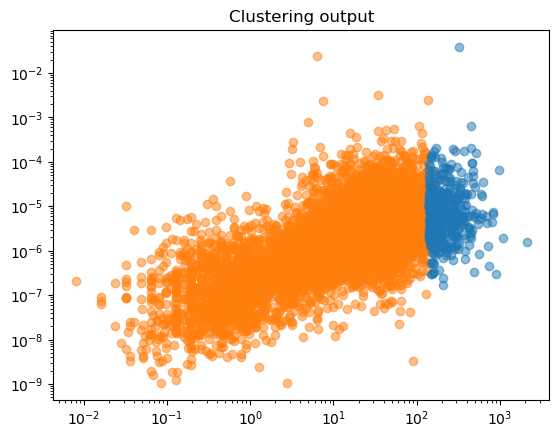

In [126]:
from sklearn.cluster import KMeans
from sklearn import preprocessing

#we need an array shape like [[x_1,y_1], ..., [x_n,y_n]]
X = np.vstack((T90_arr, fluence_arr)).T

model = KMeans(n_clusters=2, n_init='auto').fit(X)
centers = model.cluster_centers_
labels = model.predict(X)


# plot the data color-coded by cluster id
colors = ['C1', 'C0']
for ii in range(2):
    plt.scatter(X[labels==ii,0], X[labels==ii,1], 
                color=colors[ii],alpha=0.5)
    plt.xscale('log')
    plt.yscale('log')

# To get some information on these try:
# KMeans?
# help(clf)
plt.title('Clustering output');

